In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

2024-04-14 22:21:03.544713: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset-plant",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 54963 files belonging to 5 classes.


2024-04-14 22:21:53.139593: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
class_names = dataset.class_names
class_names

['Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma']

2024-04-14 22:22:52.579458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [54963]
	 [[{{node Placeholder/_4}}]]
2024-04-14 22:22:52.580983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [54963]
	 [[{{node Placeholder/_4}}]]


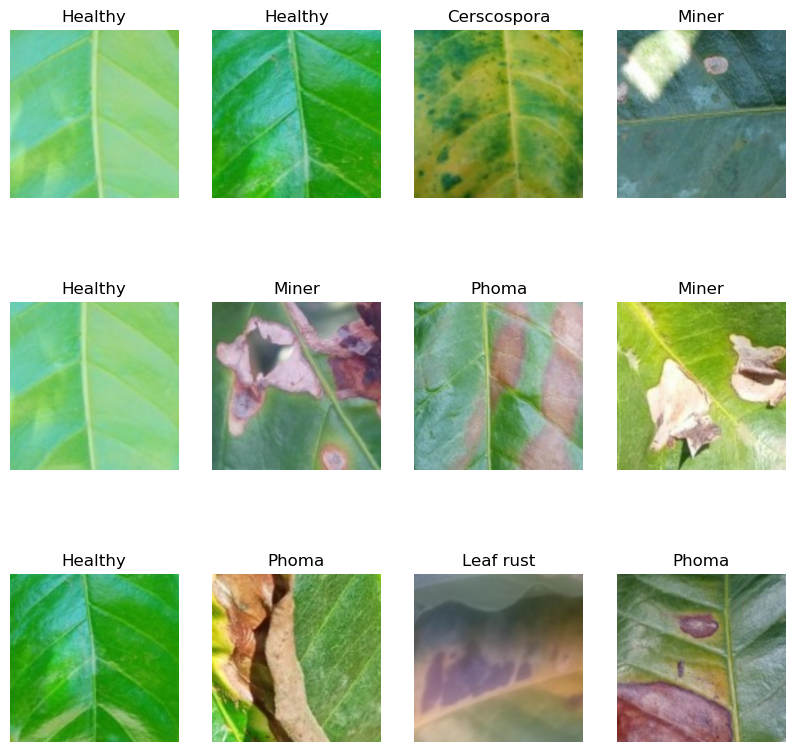

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
len(train_ds)

687

In [9]:
len(val_ds)

85

In [10]:
len(test_ds)

87

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)

])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (64, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 62, 62, 64)         0         
 2D)                                                  

In [16]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20


2024-04-14 22:26:31.999059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [54963]
	 [[{{node Placeholder/_4}}]]
2024-04-14 22:26:32.000493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [54963]
	 [[{{node Placeholder/_4}}]]
2024-04-14 22:26:48.939560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 14 of 10000
2024-04-14 22:26:58.371558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 24 of 10000
2024-04-14 22:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label:', class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predictd label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
import os

model_versions = [int(i.split(".")[0]) for i in os.listdir("../saved_models") if i.split(".")[0].isdigit()]
model_versions.append(0)
model_version = max(model_versions) + 1

model.save(f"../saved_models/{model_version}.keras")